In [1]:
import math
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame,Series

In [2]:
rho = 2700 #kg/m³
cp = 900 #J/kg.°C
k = 230 #W/m°C
ri = 0.050 #m
re = 0.056 #m
T_infinito = 80 #°C
h = 20000 #W/m².°C
Ti = 80 #°C
H = 1 #m²

pi = math.pi

In [3]:
def T_sup(t):
    T_sup = 150 + 50 * math.cos(50 * pi * t)
    return T_sup

In [97]:
mesh = 5
deltar = (re-ri)/(mesh-1)

time = 299
deltat = 0.004

In [98]:
def TDMA(A,B):   
# o vetor de coeficientes P poderia ser definida
#no procedimento principal, mas para fazer um método 
#genérico de resolução TDMA ela é definida aqui
    P = np.zeros(mesh)
    Q = np.zeros(mesh)
    #T = np.zeros((mesh,1))  
    T = np.zeros(mesh)
    Matrix_P = np.zeros((mesh,mesh))
    Matrix_Q = np.zeros((mesh,1))
    
    #print(B)
    
    Q[0] = B[0]/A[0,0]  
    P[0] = A[0,1]/A[0,0]
    

    for i in range(1,mesh):        
        Q[i] = (B[i] + A[i,i-1]*Q[i-1])/(A[i,i] - A[i,i-1]*P[i-1])
        if (i<mesh-1):
            P[i] = A[i,i+1]/(A[i,i] - A[i,i-1]*P[i-1])
        
        
    '''
    for i in range(mesh):
        Matrix_P[i,i] = 1            
        Matrix_Q[i,0] = Q[i]
        
        if (i< mesh-1):
            Matrix_P[i,i+1] = -P[i]
    T = solve(Matrix_P,Matrix_Q)  
    '''
    T[mesh-1] = Q[mesh-1]
    for i in range(mesh-2,-1,-1):
        T[i] = P[i] *T[i+1] + Q[i]
        
       
    
    
    #print(Matrix_Q)
    #return T.transpose()
    return T


In [99]:
#método numérico
T = np.zeros((time,mesh))
q = np.zeros((time,mesh))
#M = rho * H * deltar
x_plot = np.zeros(mesh)
t_plot = np.zeros(time)

Matrix_coef_a = np.zeros((mesh,mesh))
Matrix_coef_b = np.zeros((mesh,1))

x_plot[0] = ri
t_plot[0] = 0
for volume in range(mesh):
    T[0,volume] = Ti 
    if volume>0:
        x_plot[volume] = x_plot[volume-1] +deltar

T[0,0] = T_sup(0)
'''
for t in range (time):
    if t>0:
        t_plot[t] = t_plot[t-1] + deltat
'''
#Definição da matriz de coeficientes        
for r in range(mesh): 
    if (r == 0):
        ap = 1                
        Matrix_coef_a[0,0] = ap
                    
    if (r > 0) and (r < mesh-1):
        ae = k*H*2*pi*(x_plot[r]+deltar/2)/deltar #malha igualmente espaçada
        aw = k*H*2*pi*(x_plot[r]-deltar/2)/deltar
        ap0 = rho*cp*pi*H*((x_plot[r]+deltar/2)**2 - (x_plot[r]-deltar/2)**2)/deltat
        ap = ap0 + ae + aw
            
        Matrix_coef_a[r,r-1] = aw #coloquei como positivo para utilizar no TDMA
        Matrix_coef_a[r,r+1] =ae #não precisaria definir matrizes de coef A e B,
        Matrix_coef_a[r,r] = ap #porém fiz essa opção para obter um método
        #Matrix_coef_b[r,0] = b #genérico de TDMA
            
            
    if (r == mesh-1):
        aw = k*H*2*pi*(x_plot[r]-deltar/2)/deltar
        ap0 = rho*cp*pi*H*(x_plot[r]**2 - (x_plot[r]-deltar/2)**2)/deltat
        ap = ap0 + aw + 2*pi*H*h*x_plot[r]
        #b = 2*pi*re*H*h*T_infinito
            
        Matrix_coef_a[r,r-1] = aw
        Matrix_coef_a[r,r] = ap
t = 1 
eps = 1
while (eps > 1e-3):            
#for t in range(1,time):
    for r in range(mesh):
        if (r==0):            
            b = T_sup(t*deltat)            
            
            Matrix_coef_b[0,0] = b 
            
        if (r > 0) and (r < mesh-1):
            ap0 = rho*cp*pi*H*((x_plot[r]+deltar/2)**2 - (x_plot[r]-deltar/2)**2)/deltat
            
            Matrix_coef_b[r,0] = ap0*T[t-1,r]
            
        if (r == mesh-1):
            ap0 = rho*cp*pi*H*(x_plot[r]**2 - (x_plot[r]-deltar/2)**2)/deltat
            b = 2*pi*re*H*h*T_infinito
            Matrix_coef_b[r,0] = b + ap0*T[t-1,r]
        
        
    T[t,:] = TDMA(Matrix_coef_a,Matrix_coef_b)
       
    #if (t_plot[t] > 0.04):
    eps = abs(T[t,mesh-1] - T[(t-(0.04/deltat)),mesh-1])
    t_plot[t] = t_plot[t-1] + deltat
    t += 1
    
    #T[t,:] = (solve(Matrix_coef_a,Matrix_coef_b)).transpose()      
#print(Matrix_coef_a)
#print(b)
            
                

C:\Users\Gusttav\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [100]:
T

array([[ 200.        ,   80.        ,   80.        ,   80.        ,   80.        ],
       [ 190.45084972,   93.92751196,   81.757384  ,   80.22517553,
          80.05460335],
       [ 165.45084972,  101.54297069,   84.07830331,   80.70163265,
          80.2097525 ],
       ..., 
       [ 109.54915028,  133.42719628,  136.29120152,  131.28284403,
         125.28277531],
       [ 134.54915028,  133.8066773 ,  135.30837855,  131.00881935,
         125.21958593],
       [ 165.45084972,  137.89114557,  135.04793091,  130.75783593,
         125.11288371]])

In [101]:
t_plot

array([ 0.   ,  0.004,  0.008,  0.012,  0.016,  0.02 ,  0.024,  0.028,
        0.032,  0.036,  0.04 ,  0.044,  0.048,  0.052,  0.056,  0.06 ,
        0.064,  0.068,  0.072,  0.076,  0.08 ,  0.084,  0.088,  0.092,
        0.096,  0.1  ,  0.104,  0.108,  0.112,  0.116,  0.12 ,  0.124,
        0.128,  0.132,  0.136,  0.14 ,  0.144,  0.148,  0.152,  0.156,
        0.16 ,  0.164,  0.168,  0.172,  0.176,  0.18 ,  0.184,  0.188,
        0.192,  0.196,  0.2  ,  0.204,  0.208,  0.212,  0.216,  0.22 ,
        0.224,  0.228,  0.232,  0.236,  0.24 ,  0.244,  0.248,  0.252,
        0.256,  0.26 ,  0.264,  0.268,  0.272,  0.276,  0.28 ,  0.284,
        0.288,  0.292,  0.296,  0.3  ,  0.304,  0.308,  0.312,  0.316,
        0.32 ,  0.324,  0.328,  0.332,  0.336,  0.34 ,  0.344,  0.348,
        0.352,  0.356,  0.36 ,  0.364,  0.368,  0.372,  0.376,  0.38 ,
        0.384,  0.388,  0.392,  0.396,  0.4  ,  0.404,  0.408,  0.412,
        0.416,  0.42 ,  0.424,  0.428,  0.432,  0.436,  0.44 ,  0.444,
      

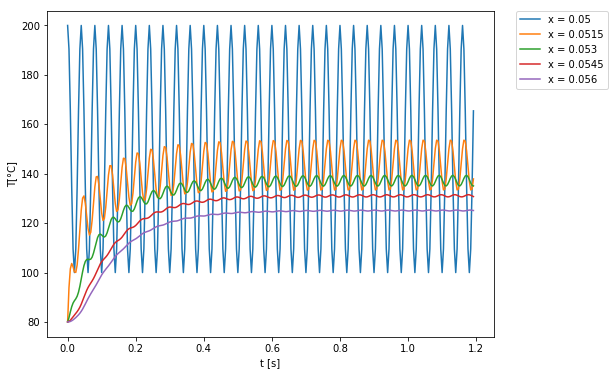

In [102]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
axis = fig.add_subplot(111)  

for x in range(mesh):    
    axis.plot(t_plot,T[:,x],label='x = '+str(x_plot[x]))
    
axis.set_ylabel('T[°C]')
axis.set_xlabel('t [s]')
axis.set_title('')
axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axis.set_ylim(30,100)
#axis.set_xlim(-0.05,0.45)
